In [86]:
import pandas as pd
import numpy as np
import calculate_cleavage_rate as clv
%matplotlib inline 
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('ticks')
current_colors = sns.color_palette()
reload(clv)
import sys
import Nucleaseq_data_processing as processing
reload(processing)
import create_fake_data as cr
reload(cr)
sys.path.append('../code_general_Finkelsteinlab')
import plotting_Finkelsteinlab as pltData
reload(pltData);
from scipy.optimize import curve_fit

model_ID = 'Clv_Saturated_general_energies_v2'
times = [0.0,12.0,60.0,180.0,600.0,1800.0,6000.0,18000.0,60000.0]
guide = 20

path_data = '../data_nucleaseq_Finkelsteinlab/targetE/'
filename_data = 'ECas9_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'

### Show result of fit

In [87]:
filename = 'fit_7_3_2019_sim_3.txt'
path = '7_3_2019/'
data = pd.read_table(path+filename,index_col=False)
final_par = data.loc[len(data)-1,'Parameter 1':'Parameter 42']
final_par_np = final_par.values
chi = data.loc[:,'Potential']
data.tail()

,Parameter 1,Parameter 2,Parameter 3,Parameter 4,Parameter 5,Parameter 6,Parameter 7,Parameter 8,Parameter 9,Parameter 10,...,Parameter 35,Parameter 36,Parameter 37,Parameter 38,Parameter 39,Parameter 40,Parameter 41,Parameter 42,Potential,Equilibruim
547,-3.146285,3.466150,-5.330826,0.002828,0.451479,-0.580938,0.050835,1.913969,3.628131,-1.370267,...,9.748106,9.517648,7.350539,5.247592,7.241239,6.560896,2.988869,-0.680353,16441.896661,True
548,-3.199676,3.549893,-5.359404,0.088587,0.381779,-0.573676,0.016872,1.910594,3.635311,-1.379366,...,9.721632,9.514314,7.364831,5.277782,7.301584,6.472456,2.992644,-0.687019,16454.279060,True
549,-3.161245,3.493545,-5.378707,0.076333,0.357683,-0.569423,0.037809,1.857835,3.637827,-1.390574,...,9.681864,9.474906,7.323640,5.195003,7.304614,6.411894,2.999639,-0.683212,16451.477208,True
550,-3.150684,3.489461,-5.265511,-0.059711,0.344519,-0.541970,0.121435,1.848316,3.638254,-1.431331,...,9.717869,9.475693,7.334110,5.205448,7.326691,6.499874,2.997136,-0.683495,16449.134828,True
551,-3.121092,3.468560,-5.333999,0.013890,0.273172,-0.499582,0.116375,1.820250,3.610281,-1.446006,...,9.649692,9.518063,7.387607,5.226923,7.302169,6.477136,2.999752,-0.680086,16452.826097,True


### Comparing to Boyle Parameters

Text(0.5,1,'difference in parameters squared')

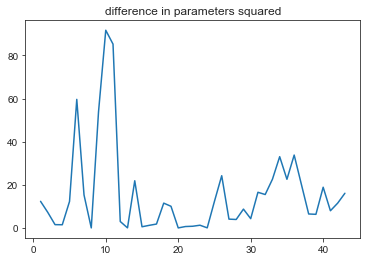

In [50]:
parameters = np.loadtxt('example-params-2.txt')
difference_sqrd = (parameters-final_par_np)**2
plt.figure
plt.plot(range(1,44),difference_sqrd)
plt.title('difference in parameters squared')

### Errorbars, weighted average kclv

In [96]:
filename = 'ECas9_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'
path_to_data = '../data_nucleaseq_Finkelsteinlab/targetE/'
xdata, ydata, yerr = processing.prepare_multiprocessing_nucleaseq(filename,path_to_data)

pos = []
kclv = []
error = []


i = 1
while i < guide+1:
    for a in range(len(xdata)):
        if len(xdata[a])==1 and xdata[a][0]==i:
            pos.append(xdata[a][0])
            kclv.append(np.average(ydata[a], weights=np.reciprocal(yerr[a]) ))
            error.append(np.mean(yerr[a]))
            i = i + 1
    
pos.append(21)
kclv.append(np.average(ydata[0], weights=np.reciprocal(yerr[0])))
error.append(np.mean(yerr[0]))
    
pos = np.array(pos)
kclv = np.array(kclv)
error = np.array(error)

In [89]:
def f(x,a):
    return a


k_double = np.zeros([20,20])
for a in range(len(xdata)):
    if len(xdata[a])==2:
        i = xdata[a][0]
        j = xdata[a][1]
        k_double[j-1,i-1] = np.log10(np.average(ydata[a], weights=np.reciprocal(yerr[a])))
        #k_double[i-1,j-1] = np.log10(curve_fit(f,range(len(ydata[a])),ydata[a],10**(-3),yerr[a])[0])
        
k_double_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1, 21))


## Single mismatches

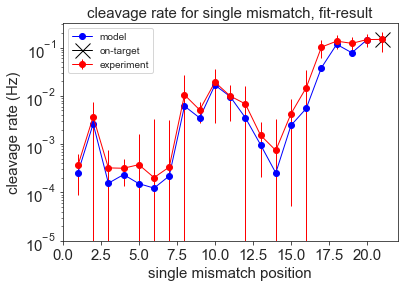

In [114]:
data_exp = pd.read_csv(path_data + filename_data)
k_exp_pd = pltData.plot_single_mut_data(data_exp, 'cleavage_rate', 'r', Canonical=True, data_name='cleavage rate (Hz)', Plot=False, 
                                                    logplot=False, SaveFigures=False)
k_exp = k_exp_pd.values[:,1]

_, k_fake, _ = cr.create_fake_data()
k_fake = k_fake[1:21]

k = np.zeros(20)
for i in range(1,guide+1):
    mismatch = [i]
    k[i-1] = clv.calc_clv_rate_fast(final_par_np,model_ID,mismatch,guide)
    
plt.figure
plt.semilogy(range(1,21),k, marker='o', linewidth=1, color='blue')
#plt.semilogy(range(1,21),k_exp, marker='o', linewidth=1, color='red')
plt.errorbar(pos,kclv,error, marker='o', linewidth=1, color='red')
plt.xlabel('single mismatch position', fontsize=15)
plt.ylabel('cleavage rate (Hz)', fontsize=15)
plt.title('cleavage rate for single mismatch, fit-result', fontsize=15)
plt.semilogy(21,clv.calc_clv_rate_fast(final_par_np,model_ID,[],guide),marker='x',markersize=15,linewidth=1,color='black') #ontarget
plt.legend(['model','on-target','experiment'])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0,22,10**(-5),10**(-0.5)]);

## Double mismatches

Text(0.5,1,'double mismatches, top=model bottom=experiment')

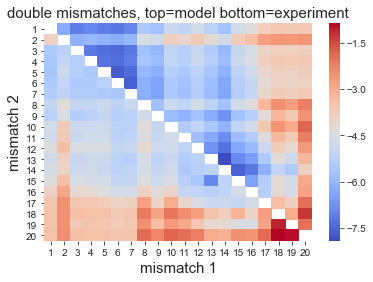

In [91]:
#data_exp = pd.read_csv(path_data + filename_data)
#_, k_matrix_experiment = pltData.plot_double_mut_data(data_exp, 'cleavage_rate', 'r', Canonical=True, Ng=20, data_name='cleavage rate (Hz)', Plot=False, logplot=True,
#                        SaveFigures=False, figure_name='./Figure.pdf')
#k_matrix_experiment.fillna(0, inplace=True)

k_matrix = np.zeros([20,20])
#k_matrix_fake = np.zeros([20,20])

for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        k_matrix[i-1,j-1] = np.log10(clv.calc_clv_rate_fast(final_par_np,model_ID,mismatch_positions,guide))
        
#for i in range(1,20):
#    for j in range(i+1,21):
#        mismatch_positions = [i,j]
#        k_matrix_fake[j-1,i-1] = np.log10(clv.calc_clv_rate_fast(parameters,model_ID,mismatch_positions,guide))
        
k_df = pd.DataFrame(k_matrix, index=range(1, 21), columns=range(1, 21))
#k_df_fake = pd.DataFrame(k_matrix_fake, index=range(1, 21), columns=range(1, 21))
combined_df = k_df + k_double_df
#combined_df_fake = k_df + k_df_fake

for i in range(1,21):
    combined_df[i].loc[i]=np.nan
#    combined_df_fake[i].loc[i]=np.nan

sns.heatmap(combined_df, cmap='coolwarm', cbar=True)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)
plt.title('double mismatches, top=model bottom=experiment', fontsize=15)


## Chi squared evolution

(array([15000., 20000., 25000., 30000., 35000., 40000.]),
 <a list of 6 Text yticklabel objects>)

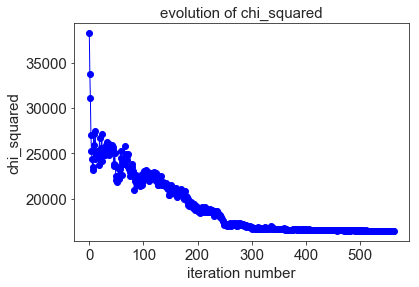

In [24]:
plt.plot(chi, marker='o', linewidth=1, color='blue')
plt.xlabel('iteration number', fontsize=15)
plt.ylabel('chi_squared', fontsize=15)
plt.title('evolution of chi_squared', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)